# Прогнозирование температуры звезды

## Описание

В обсерватории при изучении звезд различными методами высчитыват температуру на поверкхности звезды. Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

### Цель

Придумать, как с помощью нейросети определять температуру на поверхности обнаруженных обсерваторией звёзд.


### Задачи:

1. Ознакомиться со статистическими данными.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных.
4. Добавить полезные признаки.
5. Построить простую модели нейронной сети — baseline.
6. Улучшить нейронную сеть.
7. Сделать выводы.

План проведения совпадает с задачами проекта.

### Исходные данные

Характеристики:

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.


## Загрузка данных

### Загрузка библиотек, установка констант, фиксирование времени начала работы программы

In [1]:
#!pip install phik -q
#!pip install skorch -q
#!pip install --upgrade scikit-learn

In [2]:
# Загрузка библиотек
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import sklearn

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from math import ceil
from sklearn.metrics import r2_score, make_scorer
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
print(sklearn.__version__)

1.6.1


In [4]:
start_1 = time.time() #засечем время выполнения программы

In [5]:
RANDOM_STATE = 123 #зафиксируем выбор произвольных переменных

plt.rcParams["figure.figsize"] = (10,8)

learning_rate = 0.01*50
epochs = 100
batch_size = 60
accumulation_iteration = 5*2

seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
#Загрузка данных из файла с сервера или локально, создание функции
def func_os(z1,z2):
    if os.path.exists(z1):
        geo_data = pd.read_csv(z1, index_col=0)
    elif os.path.exists(z2):
        geo_data = pd.read_csv(z2, index_col=0)
    else:
        print('Something is wrong')
    return geo_data

Загружаем датасет и знакомимся.

In [7]:
d1 = '/datasets/6_class.csv'
d2 = '6_class.csv'

data = func_os(d1,d2)
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


### Знакомство с данными

In [8]:
def prep(df): #создадим функцию
    print(df.info())

    print ("Количество дубликатов:", df.duplicated().sum())

    print('Уникальные значения в столбцах (первые 50):')
    i=0
    for i in df.columns:
        try:
            print(f"  В столбце  {i}  такие уникальные значения:")
            print(df[i].sort_values().unique()[:50])
        except:
            print ('Похоже, ошибка в типе данных в столбце', i)
        print()    
    j=0
      
    return df.sample(5, random_state=RANDOM_STATE)

In [9]:
prep(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB
None
Количество дубликатов: 0
Уникальные значения в столбцах (первые 50):
  В столбце  Temperature (K)  такие уникальные значения:
[1939 2600 2621 2637 2650 2700 2731 2774 2778 2799 2800 2817 2831 2835
 2840 2856 2861 2871 2889 2890 2914 2935 2945 2968 2983 2989 2994 3008
 3042 3068 3091 3095 3100 3129 3134 3142 3146 3150 3158 3180 3192 3200
 3212 3218 3225 3243 3257 3270 3295 3304]

  В столбце  Luminosit

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
128,2856,0.000896,0.0782,19.56,0,Red
160,25390,223000.000000,57.0000,-5.92,4,Blue
62,2983,0.000240,0.0940,16.09,0,Red
206,24020,0.001590,0.0127,10.55,2,Blue
79,3158,0.001350,0.1610,13.98,1,Red


**Вывод при первом знакомстве**: 

- 240 строк, 7 столбцов;
- пропусков нет, дубликатов нет;
- типы столбцов соответствуют данным, которые в них содержатся.

**Требуемая предобработка:**

- Необходимо названия столбцов привести к "змеиному" виду
- данные в столбце Star color необходимо привести к единообразию: с маленькой буквы, двойной цвет отразить через дефис;
- разряды чисел в столбцах несопоставимы, потребуется стандартизация данных при подготовке.

## Предобработка и анализ данных

### Предобработка данных

#### Змеиный регистр столбцов

In [10]:
data.columns = data.columns.str.lower().str.replace(r'[\s\-\/]+', '_', regex=True)
data.columns

Index(['temperature_(k)', 'luminosity(l_lo)', 'radius(r_ro)',
       'absolute_magnitude(mv)', 'star_type', 'star_color'],
      dtype='object')

Для удобства копирования названия столбцов уберем скобки.

In [11]:
data.columns = data.columns.map(lambda x: x.replace('(', '_', 1).replace(')', '', 1))

data.columns

Index(['temperature__k', 'luminosity_l_lo', 'radius_r_ro',
       'absolute_magnitude_mv', 'star_type', 'star_color'],
      dtype='object')

*Таким образом, названия столбцов приведены к змеиному регистру: все буквы строчные и соединены нижними подчеркиванием, слэш и скобки устранены.*

#### Единообразие цвета звезды

In [12]:
data['star_color'] = data['star_color'].str.lower().str.replace(r'[\s]+', '-', regex=True)
data['star_color'] = data['star_color'].str.rstrip("-").str.rstrip()
sorted(data['star_color'].unique()) 

['blue',
 'blue-white',
 'orange',
 'orange-red',
 'pale-yellow-orange',
 'red',
 'white',
 'white-yellow',
 'whitish',
 'yellow-white',
 'yellowish',
 'yellowish-white']

In [13]:
data['star_color'] = data['star_color'].replace(['white-yellow', 'yellow-white'], 'yellowish-white')
sorted(data['star_color'].unique()) 

['blue',
 'blue-white',
 'orange',
 'orange-red',
 'pale-yellow-orange',
 'red',
 'white',
 'whitish',
 'yellowish',
 'yellowish-white']

In [14]:
data['star_color'] = data['star_color'].replace(['pale-yellow-orange', 'orange-red'], 'orange')
data['star_color'] = data['star_color'].replace('whitish', 'white')
sorted(data['star_color'].unique()) 

['blue',
 'blue-white',
 'orange',
 'red',
 'white',
 'yellowish',
 'yellowish-white']

*Таким образом, значения в столбце "Звёздный цвет" приведены к нижнему регистру, устранены пробелы в конце слов, пробелы между цветами в двойных названиях исправлены на дефисы. Одинаковые цвета, названные по-разному устранены. Осталось 7 цветов.*

#### Проверка на дубликаты после предобработки

In [15]:
print ("Количество дубликатов:", data.duplicated().sum())

Количество дубликатов: 0


#### Промежуточный вывод:

Данные в таблице были не совсем корректно отражены, в итоге:
- названия столбцов приведены к змеиному регистру,
- значения в столбце "Звёздный цвет" приведены к нижнему регистру, устранены пробелы в конце слов, пробелы между цветами в двойных названиях исправлены на дефисы, бело-желтые, желто-белые, желтовато-белые приведены к одном уназванию.
- новых дубликатов не выявлено.

### Исследовательский анализ данных

#### Функции для анализа

In [16]:
def categ (name_column, quantity, name): #функция для анализа категориальных столбцов

    v1 = data[name_column].value_counts().head(quantity)
    print(v1)
    print()
    print('Всего значений -', data[name_column].value_counts().shape[0])

    lb1 = v1.index

    fig, ax = plt.subplots(figsize=(10, 5));

    ax.pie(v1, labels=lb1, autopct='%1.1f%%')
    display(fig)  # Чистый вывод без лишних надписей
    plt.close() 
    ax.set_title(name);
 
    return

In [17]:
def numbers(df, name_column, x_title,y_title): #функция для анализа числовых столбцов
    plt.figure(figsize=(16, 12))

    plt.subplot(2,2,1)
    df[name_column].hist(bins=20)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.title('Распределение данных')

    
    try:
        plt.subplot(2,2,3)
        df.boxplot(name_column, color = 'green')
        plt.ylabel(x_title)
        plt.title('Ящик с усами')

    except:
        print('Ящик с усами не построить')
    plt.show()
    
    print('Статистика')
    print(df[name_column].describe())

    return;

In [18]:
data.columns

Index(['temperature__k', 'luminosity_l_lo', 'radius_r_ro',
       'absolute_magnitude_mv', 'star_type', 'star_color'],
      dtype='object')

#### Количественные признаки.

##### luminosity_l_lo

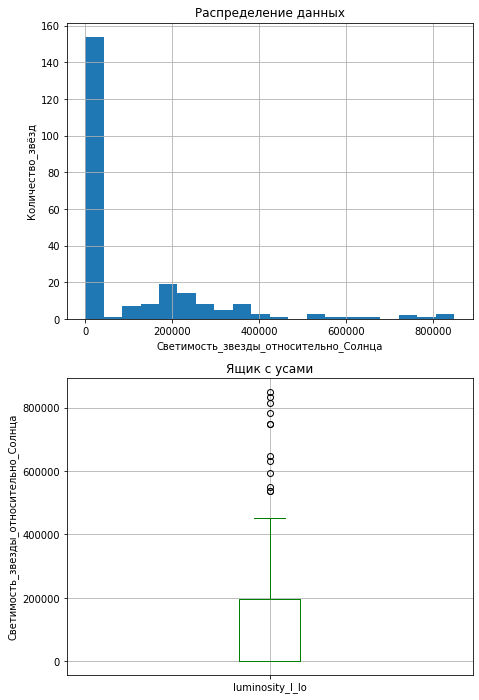

Статистика
count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity_l_lo, dtype: float64


In [19]:
numbers(data, 'luminosity_l_lo', 'Светимость_звезды_относительно_Солнца', 'Количество_звёзд')

Рассмотрим светимость от 0 до 100 000 ближе.

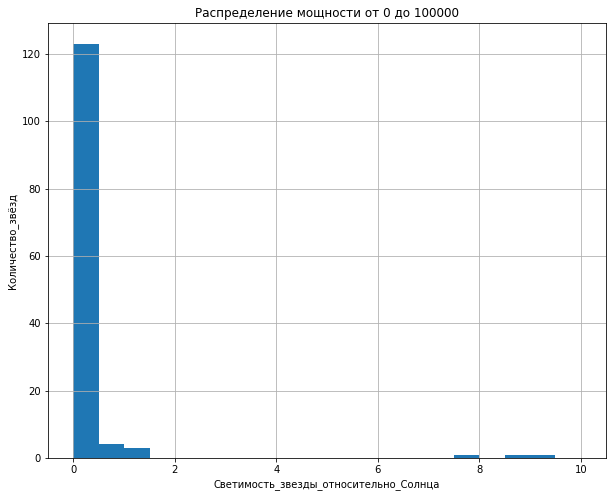

In [20]:
data['luminosity_l_lo'].hist(bins=20, range=(0,10));
plt.ylabel('Количество_звёзд')
plt.xlabel("Светимость_звезды_относительно_Солнца")
plt.title('Распределение мощности от 0 до 100000');

Светимость основной части звезд (более 120 шт) около от 0 до 0,5. Также более 60 звезд имеют светимость от 100000 до 350000. Есть выбросы - более 500000. Медиана очень далека от среднего значения.

Рассмотрим выбросы.

In [21]:
l = data.query('luminosity_l_lo > 500000')
print('Количество строк-выбросов -', l.shape[0])
l

Количество строк-выбросов - 12


,temperature__k,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_type,star_color
53,3749,550000.0,1648.0,-8.050,5,orange
101,40000,813000.0,14.0,-6.230,4,blue
172,4287,630000.0,1315.0,-9.200,5,orange
223,23440,537430.0,81.0,-5.975,4,blue
226,9892,593900.0,80.0,-7.262,4,blue
227,10930,783930.0,25.0,-6.224,4,blue
229,21738,748890.0,92.0,-7.346,4,blue
232,32489,648430.0,1948.5,-10.840,5,blue
233,27739,849420.0,1252.0,-7.590,5,blue-white
234,21904,748490.0,1130.0,-7.670,5,blue-white


Судя по типу, выбросы - это сверхгиганты и гипергиганты. Их немного, но они реальные. Скорее всего, ошибки нет. Удалять не будем

In [22]:
data.query('luminosity_l_lo < 0.5')['star_type'].value_counts()

0    40
1    40
2    40
3     3
Name: star_type, dtype: int64

Проверив тип этих звезд приходим к выводу, что это по 40 звёзд карликов каждого типа. При необходимости можно создать дополнительный признак, укрупнив признак светимости, оставив три типа: карлики, обычные, гиганты.

*Таким образом, половина всех звезд имеет светимость около от 0 до 0,5, а 12 гигантов имеют светимость более 500 000. Среднее значение 107 000.*

##### radius_r_ro

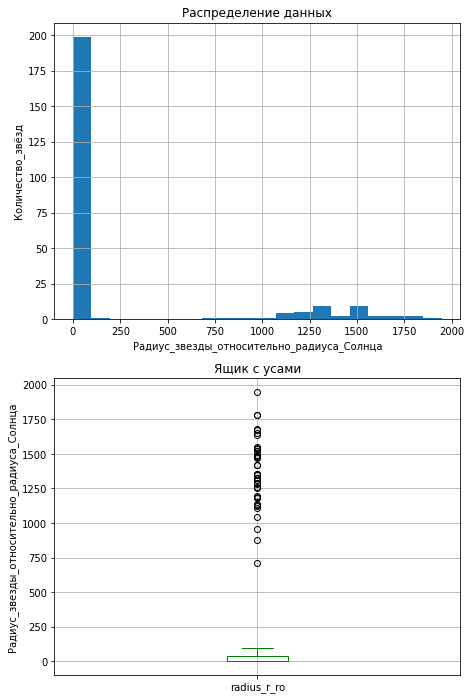

Статистика
count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius_r_ro, dtype: float64


In [23]:
numbers(data, 'radius_r_ro', 'Радиус_звезды_относительно_радиуса_Солнца', 'Количество_звёзд')

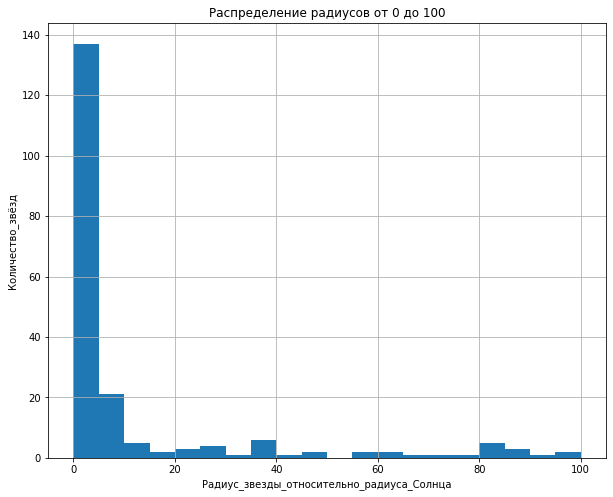

In [24]:
data['radius_r_ro'].hist(bins=20, range=(0,100));
plt.ylabel('Количество_звёзд')
plt.xlabel("Радиус_звезды_относительно_радиуса_Солнца")
plt.title('Распределение радиусов от 0 до 100');

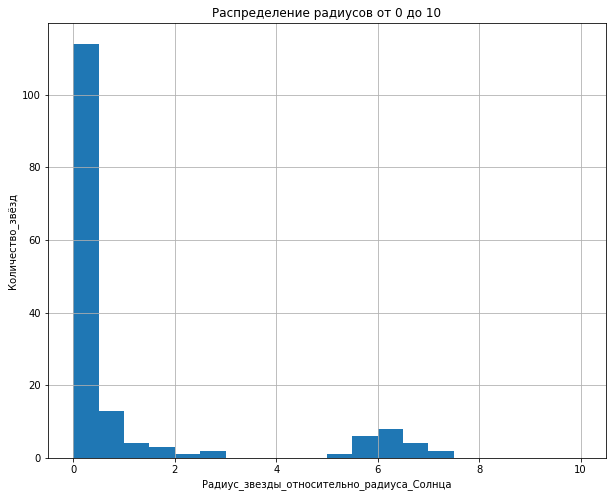

In [25]:
data['radius_r_ro'].hist(bins=20, range=(0,10));
plt.ylabel('Количество_звёзд')
plt.xlabel("Радиус_звезды_относительно_радиуса_Солнца")
plt.title('Распределение радиусов от 0 до 10');

Примерно 110 звезд имеют радиус до 0,5. Остальные больше. Есть выбросы с радиусом больше 600, поэтому медиана в сотни раз отличается от среднего. Рассмотрим выбросы.

In [26]:
l = data.query('radius_r_ro > 600')
print('Количество строк-выбросов -', l.shape[0])
l

Количество строк-выбросов - 40


,temperature__k,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_type,star_color
50,3490,270000.0,1520.0,-9.40,5,red
51,3750,283000.0,1260.0,-7.63,5,red
52,3834,272000.0,1183.0,-9.20,5,red
53,3749,550000.0,1648.0,-8.05,5,orange
54,3650,310000.0,1324.0,-7.79,5,red
55,3450,263000.0,1349.0,-11.75,5,red
56,3660,363000.0,1673.0,-11.92,5,red
57,3450,174000.0,1284.0,-11.28,5,red
58,3752,209000.0,955.0,-11.24,5,red
59,3535,195000.0,1546.0,-11.36,5,red


Достаточно большой список звезд, которые выбиваются из общего списка. Судя по типу, это всё звезды - гипергиганты. С ними ничего делать не надо.

*Таким образом, 200 звезд имеют радиус до 125, и 40 звезд, гипергиганты, имеют радиус свеше 600*.

##### absolute_magnitude_mv

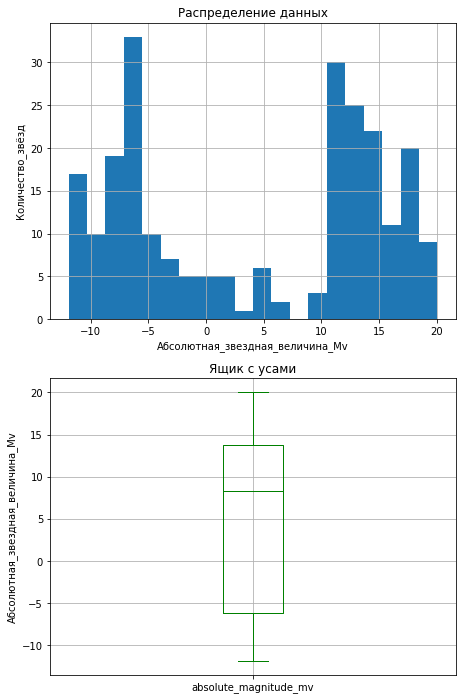

Статистика
count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: absolute_magnitude_mv, dtype: float64


In [27]:
numbers(data, 'absolute_magnitude_mv', 'Абсолютная_звездная_величина_Mv', 'Количество_звёзд')

*Таким образом, больше 30 звёзд имеют абсолютную звездную величину -6, более 75 звёзд имеют абсолютную величину от 10 до 15.Выбросов нет, но медиана смещена относительно среднего вправо.*

##### temperature__k (целевой признак)

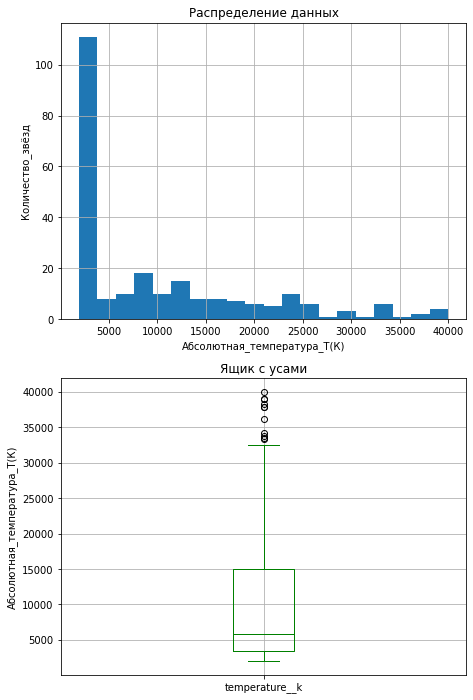

Статистика
count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature__k, dtype: float64


In [28]:
numbers(data, 'temperature__k', 'Абсолютная_температура_Т(К)', 'Количество_звёзд')

Примерно 90 (более трети) звёзд имеют температуру около 2000 К. Далее следует разброс. Есть выбросы: более 32500 К. 

Проверим выбросы.

In [29]:

l = data.query('temperature__k > 32500')
print('Количество строк-выбросов -', l.shape[0])
l

Количество строк-выбросов - 11


,temperature__k,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_type,star_color
30,39000,204000.0,10.60,-4.70,3,blue
49,33750,220000.0,26.00,-6.10,4,blue
99,36108,198000.0,10.20,-4.40,3,blue
100,33300,240000.0,12.00,-6.50,4,blue
101,40000,813000.0,14.00,-6.23,4,blue
109,33421,352000.0,67.00,-5.79,4,blue
159,37800,202900.0,6.86,-4.56,3,blue
214,34190,198200.0,6.39,-4.57,3,blue
231,38234,272830.0,1356.00,-9.29,5,blue
235,38940,374830.0,1356.00,-9.93,5,blue


Выбросы - это голубые крупные или гигантские звезды с отрицательной абсолютной величиной от -4 до -9,93. Светимость выше среднего. При изучении зависимостей между признаками  обратим внимание на зависимость между цветом звезд и температурой. Оставим эти значения для обучения.

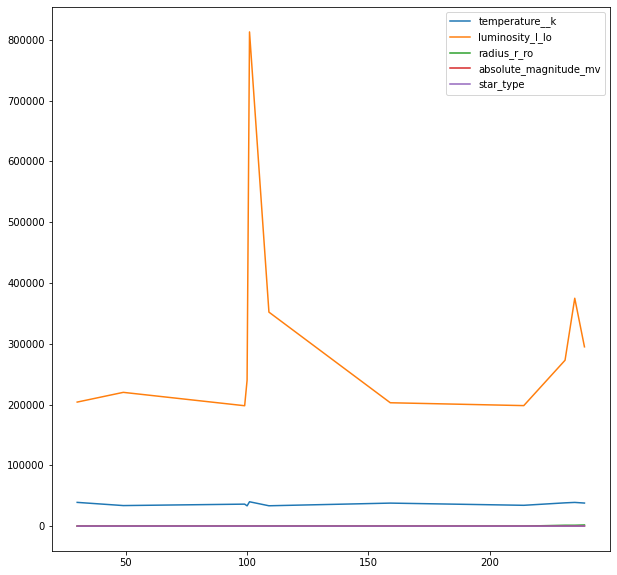

In [30]:
l.plot(figsize=(10, 10));

У одной из самых горячих звезд очень высокая светимость. Значения светимости этих звезд несопоставимы с остальными признаками. Рассмотрим признаки без светимости.

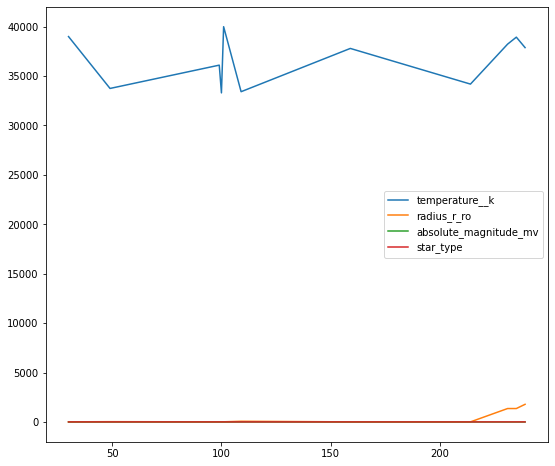

In [31]:
l.drop(['luminosity_l_lo'] , axis=1).plot(figsize=(9, 8));

Температура у выбросов колеблется от 34000 до 40000, остальные показатели в районе 0, кроме радиуса трех звезд, который выше 1 300.

*Таким образом, более трети звёзд имеют температуру около 2000 К. Далее следует разброс. Есть выбросы: 112 звёзд имеют температуру более 32500 К. Их удалять не будем.*

##### Промежуточный вывод:

1. Половина всех звезд имеет светимость около от 0 до 0,5, а 12 гигантов имеют светимость более 500 000.
2. 200 звезд имеют радиус до 125, и 40 звезд, гипергиганты, имеют радиус свеше 600.
3. больше 30 звёзд имеют абсолютную звездную величину -6, более 75 звёзд имеют абсолютную величину от 10 до 15. Выбросов нет, но медиана смещена относительно среднего вправо.
4. более трети звёзд имеют температуру около 2000 К. Далее следует разброс. Есть выбросы: 112 звёзд имеют температуру более 32500 К. 

#### Категориальные признаки

##### star_color

In [32]:
colors = data['star_color'].value_counts()
colors_df  = pd.DataFrame(colors)
colors_df['percentage'] = round((colors_df['star_color'] / data.shape[0]) * 100,1)
colors_df.rename(columns={'star_color': 'count'}, inplace=True)
colors_df

,count,percentage
red,112,46.7
blue,56,23.3
blue-white,41,17.1
white,12,5.0
yellowish-white,12,5.0
orange,4,1.7
yellowish,3,1.2


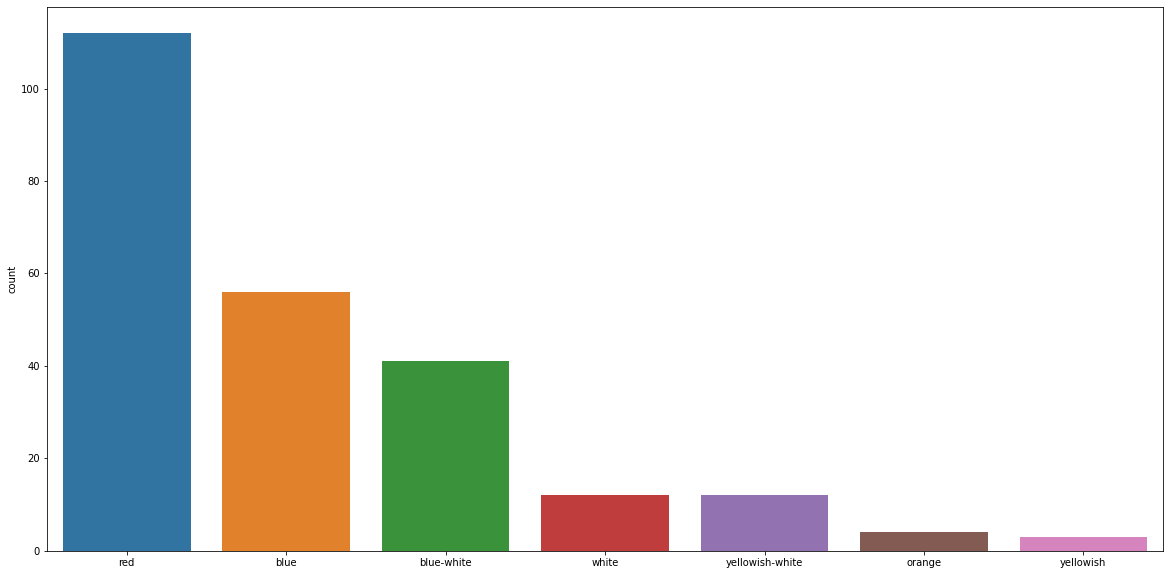

In [33]:
plt.figure(figsize=(20, 10));
sns.barplot(x= colors_df.index,y='count', data=colors_df);


red                112
blue                56
blue-white          41
white               12
yellowish-white     12
orange               4
yellowish            3
Name: star_color, dtype: int64

Всего значений - 7


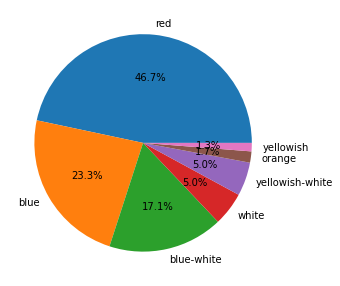

In [34]:
categ ('star_color', 20, "star_color");

*Таким образом, около половины звезд имеют цвет красный (red), около четверти голубые (blue). 7 звезд имеют очень редкие цвета, поэтому объединены в цвет other. Цвет other занимает 3,8% всех цветов.*

##### star_type

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

Всего значений - 6


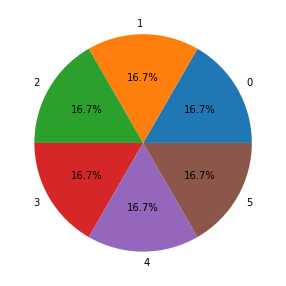

In [35]:
categ ('star_type', 6, "star_type")

Тип звезд - это категориальный признак. Приведем его к соответствующему типу.

### Перевод типа звезд в строковый тип

In [36]:
data['star_type'] = data['star_type'].apply(lambda x: str(x))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temperature__k         240 non-null    int64  
 1   luminosity_l_lo        240 non-null    float64
 2   radius_r_ro            240 non-null    float64
 3   absolute_magnitude_mv  240 non-null    float64
 4   star_type              240 non-null    object 
 5   star_color             240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 13.1+ KB


*Таким образом, по типам звезды распределены равномерно - 40 звезд каждого типа.*

##### Промежуточный вывод:

*Около половины звезд имеют цвет красный (red), около четверти голубые (blue). 7 звезд имеют очень редкие цвета.*

При необходимости можно сформировать дополнительные признаки на основе существующих.

#### Корреляционный анализ

Проверим данные на мультиколлинеарность.

In [37]:
data.columns

Index(['temperature__k', 'luminosity_l_lo', 'radius_r_ro',
       'absolute_magnitude_mv', 'star_type', 'star_color'],
      dtype='object')

##### Матрица корреляции Фи

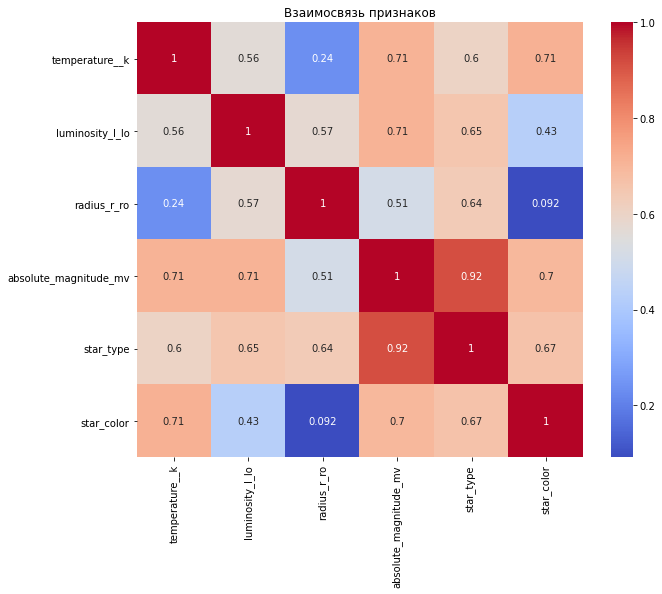

In [38]:
interval_cols = ['temperature__k', 'luminosity_l_lo', 'radius_r_ro', 'absolute_magnitude_mv']
corr_matrix = data.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Взаимосвязь признаков')
plt.show()

- *Высокая корреляция между абсолютной звёздной величиной и типом звезды - 0,92.*
- *Чуть ниже между типом звезды и цветом звезды - 0,86.*
- *Зависимости с температурой есть, но утечки нет.*
- *Обращая внимание на зависимость между цветом и температурой, видим, что эта зависимость небольшая.*

##### Диаграмма рассеяния

                       temperature__k  luminosity_l_lo  radius_r_ro  \
temperature__k               1.000000         0.393404     0.064216   
luminosity_l_lo              0.393404         1.000000     0.526516   
radius_r_ro                  0.064216         0.526516     1.000000   
absolute_magnitude_mv       -0.420261        -0.692619    -0.608728   

                       absolute_magnitude_mv  
temperature__k                     -0.420261  
luminosity_l_lo                    -0.692619  
radius_r_ro                        -0.608728  
absolute_magnitude_mv               1.000000  


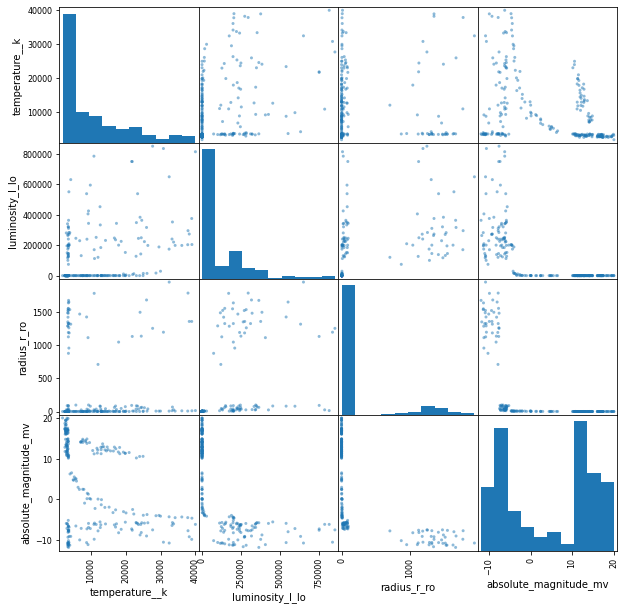

In [39]:
print(data.corr())
pd.plotting.scatter_matrix(data, figsize=(10,10))
plt.show()

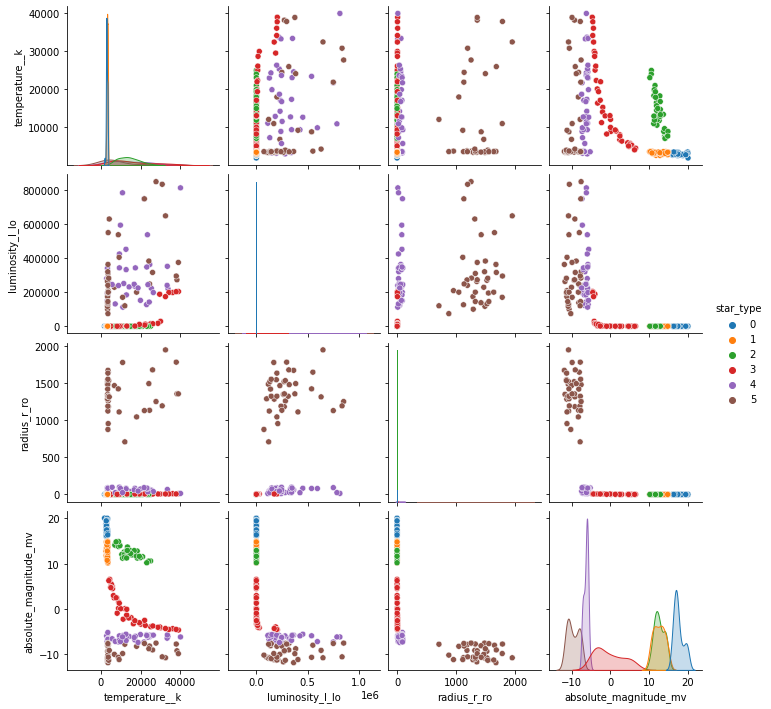

In [40]:
sns.pairplot(data, hue='star_type');

In [41]:
data.columns

Index(['temperature__k', 'luminosity_l_lo', 'radius_r_ro',
       'absolute_magnitude_mv', 'star_type', 'star_color'],
      dtype='object')

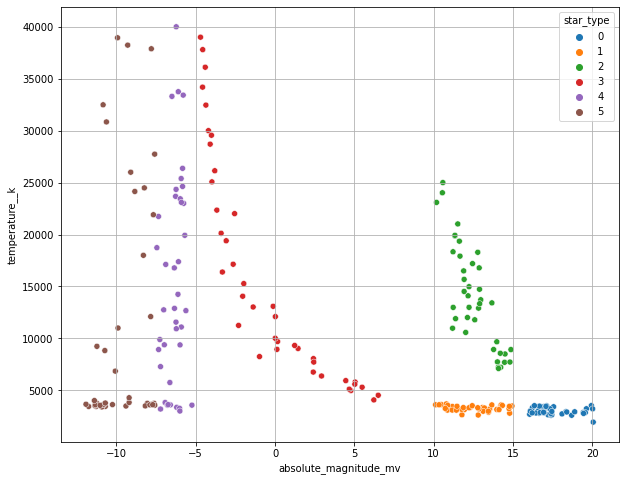

In [42]:
sns.scatterplot(data=data, x="absolute_magnitude_mv", y="temperature__k", hue="star_type")
plt.grid(True)

Диаграмма рассеяния показывает, что температура звезд 0-го и 1-го типов ниже 4000 К, а температура звезд 2-го типа от 7000 до 26000 К. Также она показывает взаимосвязь абсолютной зыездной величины и типа звезд: звёзды 4 и 5-го типов имеют величину до -5, 3-го типа от -5 до 10 (невключая), 1,2-го - от 10 до 15, 0-го от 15 и выше.

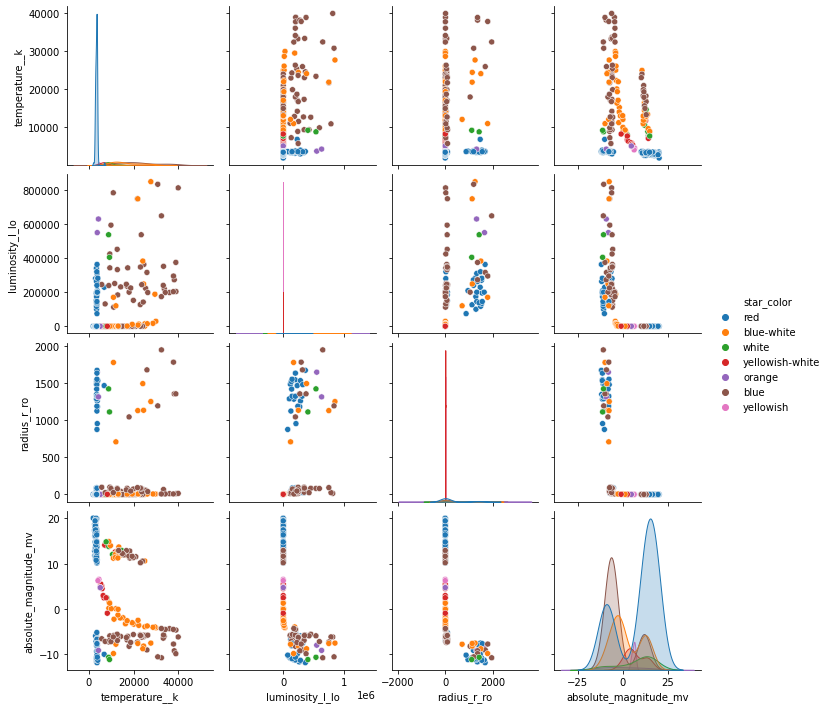

In [43]:
sns.pairplot(data.drop('star_type', axis=1), hue='star_color');

- Ожидаемо огромная светимость у звезд-гигантов.
- Самый большой радиус у гипергигантов.
- Абсолютное значение ниже -5 у звезд с большим радиусом и большой светимостью.
- При абсолютном значении выше -5, можно описать зависимость температуры от абсолютной звездной величины по графику показательной функции y=(1/3)^x.
- Абсолютная звёздная величина (absolute_magnitude_mv) и тип звезды (star_type) - важные признаки. Нейросеть должна установить зависимости.
 
  При необходимости можно добавить дополнительные категориальные признаки. 

##### Промежуточный вывод:

*Утечки целевого признака нет, мультиколлинерныости между признаками нет. Прослеживается взаимосвязь между признаками.*

### Добавление признаков

На основе графика взаимосвязи absolute_magnitude_mv и temperature__k можно сделать вывод, что график при звёзд третьего типа похож на график степенной функции, где основание степени от 0 до 1. Это подталкивает создать дополнительный признак в виде степенной функции с основанием 1/3.

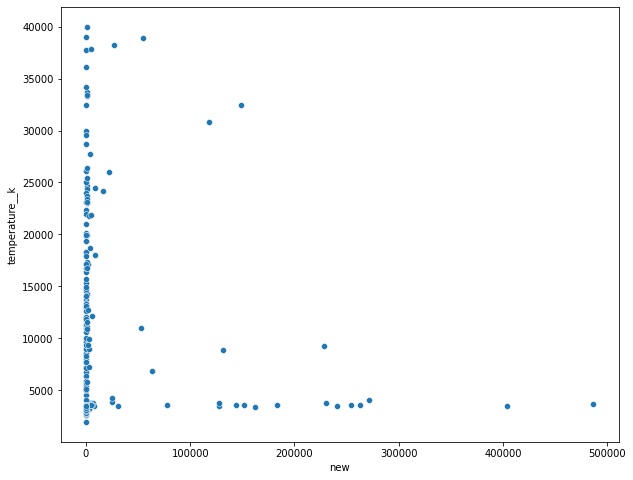

In [44]:
data['new'] = data['absolute_magnitude_mv'].apply(lambda x: (1/3)**x)


sns.scatterplot(data=data, x='new', y='temperature__k');


Входных признаков достоточно мало. Для более хорошего результата проведем полиномизацию до второго порядка количественных признаков.

In [45]:
data.columns

Index(['temperature__k', 'luminosity_l_lo', 'radius_r_ro',
       'absolute_magnitude_mv', 'star_type', 'star_color', 'new'],
      dtype='object')

In [46]:
num_columns = ['luminosity_l_lo', 'radius_r_ro', 'absolute_magnitude_mv', 'new']

poly = PolynomialFeatures(degree=2).fit(data[num_columns])
features_poly = poly.transform(data[num_columns])
df_poly = pd.DataFrame(features_poly, columns=['feature^0', 'feature^1', 'feature^2', 'feature^3', 'feature^4', 'feature^5', 'feature^6', 'feature^7','feature^8', 'feature^9', 'feature^10', 'feature^11','feature^12', 'feature^13', 'feature^14'])
df_poly.head(3)

,feature^0,feature^1,feature^2,feature^3,feature^4,feature^5,feature^6,feature^7,feature^8,feature^9,feature^10,feature^11,feature^12,feature^13,feature^14
0,1.0,0.0024,0.1700,16.12,2.036129e-08,5.760000e-06,0.000408,0.038688,4.886711e-11,0.028900,2.74040,3.461420e-09,259.8544,3.282241e-07,4.145823e-16
1,1.0,0.0005,0.1542,16.60,1.201675e-08,2.500000e-07,0.000077,0.008300,6.008377e-12,0.023778,2.55972,1.852983e-09,275.5600,1.994781e-07,1.444024e-16
2,1.0,0.0003,0.1020,18.70,1.196279e-09,9.000000e-08,0.000031,0.005610,3.588837e-13,0.010404,1.90740,1.220205e-10,349.6900,2.237042e-08,1.431084e-18


In [47]:
data_poly = pd.concat([data, df_poly], axis=1)
data_poly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temperature__k         240 non-null    int64  
 1   luminosity_l_lo        240 non-null    float64
 2   radius_r_ro            240 non-null    float64
 3   absolute_magnitude_mv  240 non-null    float64
 4   star_type              240 non-null    object 
 5   star_color             240 non-null    object 
 6   new                    240 non-null    float64
 7   feature^0              240 non-null    float64
 8   feature^1              240 non-null    float64
 9   feature^2              240 non-null    float64
 10  feature^3              240 non-null    float64
 11  feature^4              240 non-null    float64
 12  feature^5              240 non-null    float64
 13  feature^6              240 non-null    float64
 14  feature^7              240 non-null    float64
 15  featur

Проверим новые признаки на мультиколлинеарность.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable feature^0 for analysis 1. Dropping this column
  warnings.warn(


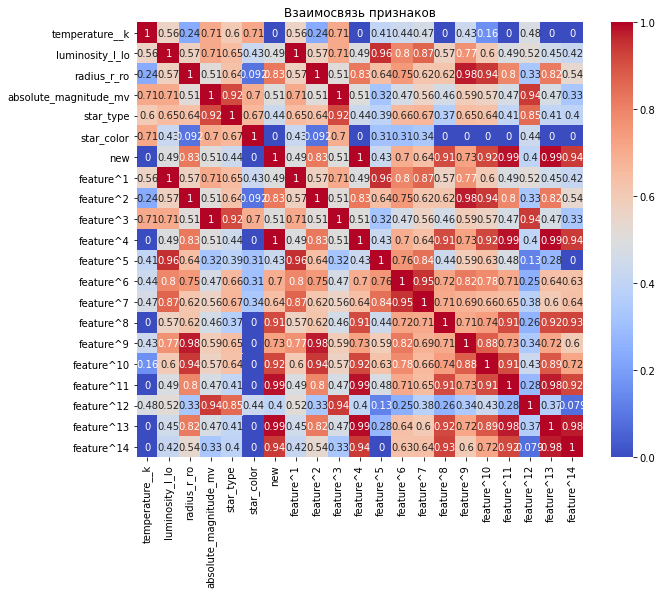

In [48]:
interval_cols = ['temperature__k', 'luminosity_l_lo', 'radius_r_ro', 'absolute_magnitude_mv', 'new','feature^0', 'feature^1', 'feature^2', 'feature^3', 'feature^4', 'feature^5', 'feature^6', 'feature^7','feature^8', 'feature^9', 'feature^10', 'feature^11','feature^12', 'feature^13', 'feature^14']
corr_matrix = data_poly.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Взаимосвязь признаков')
plt.show()

Сильно коррелирующие признаки удалим.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable feature^0 for analysis 1. Dropping this column
  warnings.warn(


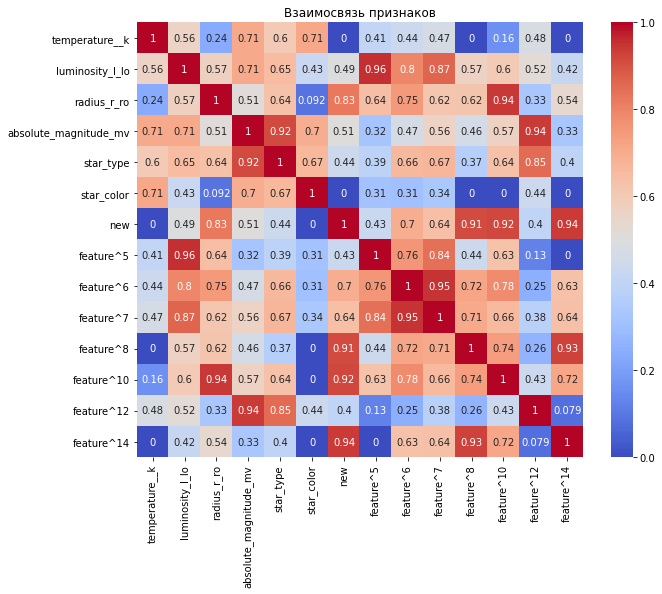

In [49]:
highly_corr = ['feature^1', 'feature^2','feature^9', 'feature^3', 'feature^11', 'feature^4', 'feature^13']

data_poly = data_poly.drop(highly_corr,axis=1)

interval_cols = ['temperature__k', 'luminosity_l_lo', 'radius_r_ro', 'absolute_magnitude_mv', 'new','feature^0', 'feature^5', 'feature^6', 'feature^7','feature^8', 'feature^10','feature^12', 'feature^14']
corr_matrix = data_poly.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Взаимосвязь признаков')
plt.show()

#### Промежуточный вывод:
*Таким образом, добавлен новый признак, его значения равны $\left( \frac{1}{3} \right)^x$, где х - значения столбца Абсолютная звёздная величина.А также полиномизацией добавлены дополнительные признаки.*

## Построение базовой нейронной сети

### Подготовка данных

In [50]:
display(data_poly.head())
data_poly.info()

,temperature__k,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_type,star_color,new,feature^0,feature^5,feature^6,feature^7,feature^8,feature^10,feature^12,feature^14
0,3068,0.002400,0.1700,16.12,0,red,2.036129e-08,1.0,5.760000e-06,0.000408,0.038688,4.886711e-11,2.74040,259.8544,4.145823e-16
1,3042,0.000500,0.1542,16.60,0,red,1.201675e-08,1.0,2.500000e-07,0.000077,0.008300,6.008377e-12,2.55972,275.5600,1.444024e-16
2,2600,0.000300,0.1020,18.70,0,red,1.196279e-09,1.0,9.000000e-08,0.000031,0.005610,3.588837e-13,1.90740,349.6900,1.431084e-18
3,2800,0.000200,0.1600,16.65,0,red,1.137447e-08,1.0,4.000000e-08,0.000032,0.003330,2.274894e-12,2.66400,277.2225,1.293785e-16
4,1939,0.000138,0.1030,20.06,0,red,2.685021e-10,1.0,1.904400e-08,0.000014,0.002768,3.705328e-14,2.06618,402.4036,7.209336e-20


<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temperature__k         240 non-null    int64  
 1   luminosity_l_lo        240 non-null    float64
 2   radius_r_ro            240 non-null    float64
 3   absolute_magnitude_mv  240 non-null    float64
 4   star_type              240 non-null    object 
 5   star_color             240 non-null    object 
 6   new                    240 non-null    float64
 7   feature^0              240 non-null    float64
 8   feature^5              240 non-null    float64
 9   feature^6              240 non-null    float64
 10  feature^7              240 non-null    float64
 11  feature^8              240 non-null    float64
 12  feature^10             240 non-null    float64
 13  feature^12             240 non-null    float64
 14  feature^14             240 non-null    float64
dtypes: flo

*Итак, мы имеем данные из 240 строк и 15 столбцов. Два киз которых имеют строковый тип, 13 - числовой.*

#### Выделение датасетов для обучения.

In [51]:
X=data_poly.drop('temperature__k', axis=1)
Y=data.temperature__k
#print(X.info())
print(X.shape)
print(Y.shape)

(240, 14)
(240,)


*Итак выделили датасет с входными признаками и целевым*.

#### Деление на выборки.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.3,
    shuffle=True,
    random_state=RANDOM_STATE,
    stratify=data_poly['star_type'])
print('Размеры тренировочных данных:')
print(X_train.shape)
print(y_train.shape)
print()
print('Размеры тестовых данных:')
print(X_test.shape)
print(y_test.shape)

Размеры тренировочных данных:
(168, 14)
(168,)

Размеры тестовых данных:
(72, 14)
(72,)


#### Масштабирование количественных признаков и кодирование категориальных

In [53]:
data_poly.columns

Index(['temperature__k', 'luminosity_l_lo', 'radius_r_ro',
       'absolute_magnitude_mv', 'star_type', 'star_color', 'new', 'feature^0',
       'feature^5', 'feature^6', 'feature^7', 'feature^8', 'feature^10',
       'feature^12', 'feature^14'],
      dtype='object')

In [54]:
num_columns = ['luminosity_l_lo', 'radius_r_ro', 'absolute_magnitude_mv', 'new',
       'feature^0', 'feature^5', 'feature^6', 'feature^7', 'feature^8',
       'feature^10', 'feature^12', 'feature^14']
cat_columns = [ 'star_type', 'star_color']

In [55]:
scaler = StandardScaler() #стандартизируем входные признаки

In [56]:
scaler.fit(X_train[num_columns])
X_train_scaled = scaler.transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)
X_train_scaled.shape

(168, 12)

In [57]:
oh_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')


In [58]:
oh_encoder.fit(X_train[cat_columns])
encoder_cat_names = oh_encoder.get_feature_names_out()
X_train_ohe = oh_encoder.transform(X_train[cat_columns])
X_test_ohe= oh_encoder.transform(X_test[cat_columns])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_cat_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_cat_names)
X_train_ohe.shape

(168, 11)

In [59]:

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train.shape

(168, 23)

In [60]:
X_train

,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue-white,star_color_orange,star_color_red,star_color_white,star_color_yellowish,...,absolute_magnitude_mv,new,feature^0,feature^5,feature^6,feature^7,feature^8,feature^10,feature^12,feature^14
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.479644,-0.292859,0.0,-0.375266,-0.369839,0.562323,-0.252441,0.444571,2.659619,-0.195684
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,-1.272553,-0.025173,0.0,0.914983,2.544849,-1.794016,0.068916,-2.133275,-0.507162,-0.182769
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.012442,-0.279374,0.0,0.094105,-0.320417,-0.421593,-0.242677,0.394028,-0.910533,-0.195651
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-1.390176,0.741056,0.0,0.086012,1.341422,-1.042620,0.489708,-2.438842,-0.276593,-0.003025
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.964628,-0.285073,0.0,1.421820,-0.178736,-1.205625,-0.241410,0.353157,-0.968723,-0.195673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,-1.215175,-0.154390,0.0,0.167872,1.066193,-0.862729,-0.144588,-1.380216,-0.608751,-0.192228
164,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.661061,-0.292859,0.0,-0.375266,-0.369839,0.562323,-0.252441,0.444211,0.001957,-0.195684
165,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.009573,-0.279811,0.0,0.658987,-0.317438,-0.891058,-0.238417,0.408536,-0.914165,-0.195653
166,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.991882,-0.282211,0.0,0.688880,-0.217467,-0.867128,-0.240832,0.345084,-0.936162,-0.195663


*Таким образом, количественные признаки стандартизированы с помощью StandardScaler(), категориальные закодированы с помощью OneHotEncoder. Теперь имеем датасеты 168х23 и 72х23*.

#### Создание тензоров

In [61]:
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)


print(X_train[:5], y_train[:5])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000, -0.5806, -0.4604,  1.4796, -0.2929,  0.0000,
         -0.3753, -0.3698,  0.5623, -0.2524,  0.4446,  2.6596, -0.1957],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.5635,  2.4392, -1.2726, -0.0252,  0.0000,
          0.9150,  2.5448, -1.7940,  0.0689, -2.1333, -0.5072, -0.1828],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.7126, -0.3791, -1.0124, -0.2794,  0.0000,
          0.0941, -0.3204, -0.4216, -0.2427,  0.3940, -0.9105, -0.1957],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.7014,  2.3868, -1.3902,  0.7411,  0.0000,
          0.0860,  1.3414, -1.0426,  0.4897, -2.4388, -0.2766, -0.0030],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.000

#### Построение модели нейронной сети

In [62]:
n_in_neurons = 23 #задаем количество входных нейронов и нейронов в скрытых слоях
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 12

In [63]:
class Net_base(nn.Module):
    def __init__(self, i = 0):
        super(Net_base, self).__init__()
        self.i=i

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        if self.i !=  0: 
            #пока нейросеть без регуряризации. В архитектуре предусмотрим включение регуляриции при необходимости
            self.dp1 = nn.Dropout(p=i)    
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)

        self.fc3 = nn.Linear(n_hidden_neurons_2, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        if self.i != 0:
            x = self.dp1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [64]:
net_base = Net_base(i=0)
print(net_base)

Net_base(
  (fc1): Linear(in_features=23, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=1, bias=True)
)


In [65]:
optimizer = optim.Adam(net_base.parameters(), lr=learning_rate)

loss = nn.MSELoss()

#### Обучение модели

In [66]:
num_batches = ceil(len(X_train)/batch_size)

In [67]:
for epoch in range(epochs):
    
    order = np.random.permutation(len(X_train))
    optimizer.zero_grad()
    for batch_i in range(num_batches):
        start_index = batch_i * batch_size
        
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
    
        preds = net_base.forward(X_batch) 
        y_batch = y_batch.view(-1, 1)
      
        
        loss_value = loss(preds, y_batch) / accumulation_iteration
        loss_value.backward()
                
        if ((batch_i + 1) % accumulation_iteration == 0) or (batch_i + 1 == num_batches):
            optimizer.step()
            optimizer.zero_grad()
            
       
    
    if epoch % 10 == 0:
        net_base.eval()
        with torch.no_grad():  
            test_preds = net_base.forward(X_test)
            
            y_test = y_test.view(-1, 1)
            
            rmse_tr = torch.sqrt(nn.MSELoss()(preds, y_batch))            
                     
            r2 = r2_score(y_test.numpy(), test_preds.numpy())
            rmse = torch.sqrt(nn.MSELoss()(test_preds, y_test))
            
            print(f"Epoch {epoch}, RMSE на тренировочных данных: {rmse_tr.item():.0f}, RMSE на тестовых данных: {rmse.item():.0f}, R²: {r2:.4f}")
  
            
            
            

Epoch 0, RMSE на тренировочных данных: 12361, RMSE на тестовых данных: 15263, R²: -1.0997
Epoch 10, RMSE на тренировочных данных: 7826, RMSE на тестовых данных: 9567, R²: 0.1750
Epoch 20, RMSE на тренировочных данных: 5857, RMSE на тестовых данных: 9047, R²: 0.2622
Epoch 30, RMSE на тренировочных данных: 5351, RMSE на тестовых данных: 7904, R²: 0.4370
Epoch 40, RMSE на тренировочных данных: 4880, RMSE на тестовых данных: 7706, R²: 0.4647
Epoch 50, RMSE на тренировочных данных: 5107, RMSE на тестовых данных: 6876, R²: 0.5739
Epoch 60, RMSE на тренировочных данных: 3655, RMSE на тестовых данных: 6148, R²: 0.6593
Epoch 70, RMSE на тренировочных данных: 2139, RMSE на тестовых данных: 5524, R²: 0.7250
Epoch 80, RMSE на тренировочных данных: 3602, RMSE на тестовых данных: 5112, R²: 0.7645
Epoch 90, RMSE на тренировочных данных: 4353, RMSE на тестовых данных: 4806, R²: 0.7918


 
Нейронная сеть обучилась, метрика резко снизилась на 10-й эпохе, далее падала плавно. RMSE нормальный. Дополнительно рассмотрен коэффициент детерминации $R^{2}$=0,79, который говорит о средней способности предсказывать. 

#### График факт-прогноз

In [68]:
k=25 #количество звезд, значений, на графике

In [69]:
y_test_num =y_test.numpy()
test_preds_num = test_preds.numpy()

In [70]:
y_test_list = y_test_num.flatten().tolist()[:k]
test_preds_list = test_preds_num.flatten().tolist()[:k]


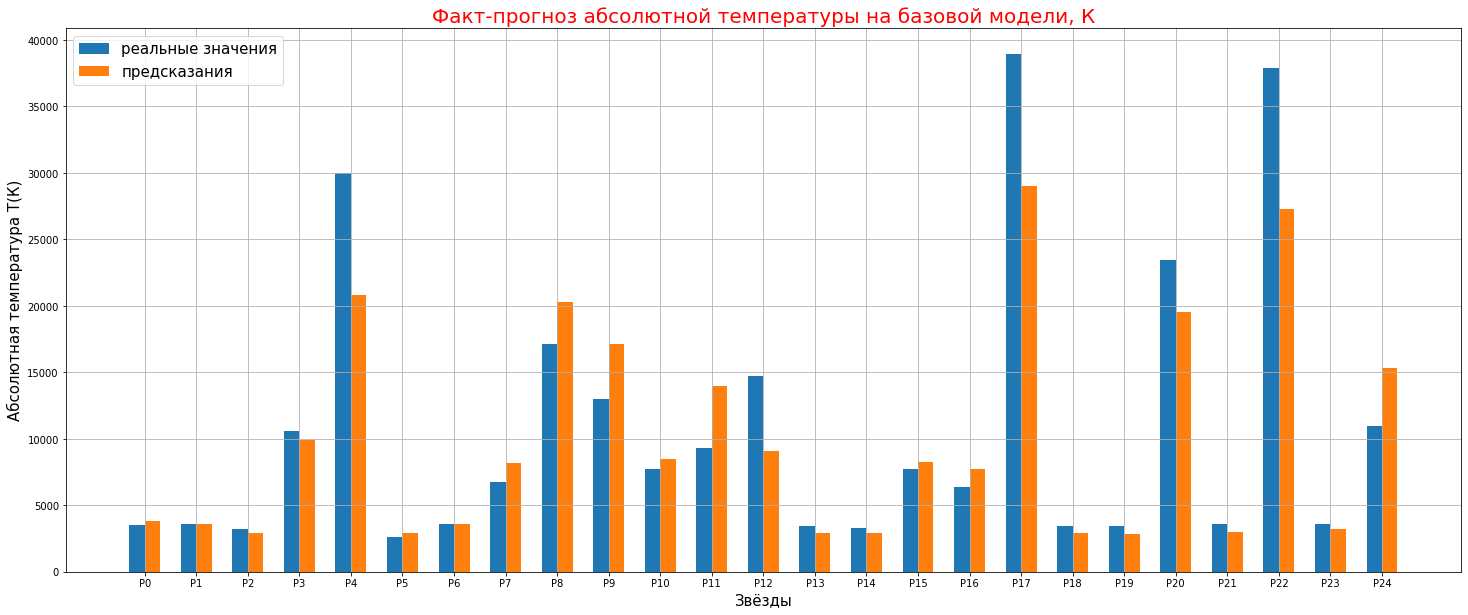

In [71]:

cat_par = [f"P{i}" for i in range(k)]
width = 0.3
x = np.arange(len(cat_par))
fig, ax = plt.subplots(figsize=(k, 10))
rects1 = ax.bar(x - width/2, y_test_list, width, label='реальные значения')
rects2 = ax.bar(x + width/2, test_preds_list, width, label='предсказания')
ax.set_title('Факт-прогноз абсолютной температуры на базовой модели, К', fontsize=20, color='red')
ax.set_xticks(x)
ax.set_xticklabels(cat_par)
ax.legend(fontsize=15)
ax.set_xlabel("Звёзды", fontsize=15)
ax.set_ylabel("Абсолютная температура Т(К)", fontsize=15)
ax.grid(True);

*Таким образом, получена модель нейронной сети c двумя скрытыми слоями, 23-мя входящими нейронами и одним исходящим. Модель обучилась, о чем говорит снижение метрики от 0 эпохи к 90-й. Модель в среднем качестве предсказывает абсолютную температару поверхности звезды, о чем говорит корень из среднеквадратичной ошибки RMSE = 4806 и коэффициент детерминации $R^{2}$ = 0,79.*

*График факт-прогноз наглядно демонстрирует, что предсказания часто близки к реальным значениям*.

## Улучшение нейронной сети

#### Циклы

Перебирая параметры ищем лучшую метрику.

In [72]:
learning_rates = [0.001, 0.01, 0.1, 0.5, 0.6]
batch_sizes = [30, 32, 40, 60, 64, 80, 120]
pn = [0, 0.1, 0.2, 0.5, 0.7, 0.8]
best_rmse =[]
row = []
mat=[]

In [73]:
best_metrics = 13000

In [74]:
for j in pn:

         
    net_best = Net_base(i=j) #создаем нвый объект на основе псотроенного ранее класса, инициализируем Dropout

    
    loss = nn.MSELoss()

    for lrate in learning_rates:
        optimizer = optim.Adam(net_best.parameters(), lr=lrate)
 
        for bs in batch_sizes:

            num_batches = ceil(len(X_train)/bs)
    
            for epoch in range(epochs):
    
                order = np.random.permutation(len(X_train))
                optimizer.zero_grad()
                for batch_i in range(num_batches):
                    
                    seed=42
                    random.seed(seed)
                    np.random.seed(seed)
                    torch.manual_seed(seed)
                    torch.cuda.manual_seed_all(seed)
            
                    start_index = batch_i * bs
        
                    batch_indexes = order[start_index:start_index+bs]
                    X_batch = X_train[batch_indexes]
                    y_batch = y_train[batch_indexes]
    
                    preds = net_best.forward(X_batch) 
                    y_batch = y_batch.view(-1, 1)
        
                    loss_value = loss(preds, y_batch) / accumulation_iteration
                    loss_value.backward()
                
                    if ((batch_i + 1) % accumulation_iteration == 0) or (batch_i + 1 == num_batches):
                        optimizer.step()
                        optimizer.zero_grad()            
       
    
                if epoch % 10 == 0:
                    net_best.eval()
                    with torch.no_grad(): 
                        test_preds = net_best.forward(X_test)
            
                        y_test = y_test.view(-1, 1)
            
                        rmse_tr = torch.sqrt(nn.MSELoss()(preds, y_batch))            
            
                        r2 = r2_score(y_test.numpy(), test_preds.numpy())
                        rmse = torch.sqrt(nn.MSELoss()(test_preds, y_test))
            #формируем строки для датасета
                        row=[epoch, j, rmse_tr.item(), lrate, bs, rmse.item(), r2 ]
                        mat.append(row)
            #ищем минимальный RMSE        
                        if rmse.item() < best_metrics:
                            best_metrics = rmse.item()
                            y_test_num =y_test.numpy()
                            test_preds_num = test_preds.numpy()
                            

In [75]:
df = pd.DataFrame(data=mat, columns = ['epoch', 'p','rmse_tr', 'learning_rate', 'batch_size', 'rmse', 'r2'])
display(df)
min_rmse = df.rmse.min()

best_param = df[df['rmse'] == min_rmse]

print('Лучшие результаты:') #отражаем минимальный RMSE в таблице
best_param

,epoch,p,rmse_tr,learning_rate,batch_size,rmse,r2
0,0,0.0,11478.791992,0.001,30,15327.904297,-1.117701
1,10,0.0,15421.963867,0.001,30,15327.864258,-1.117690
2,20,0.0,15421.916992,0.001,30,15327.814453,-1.117676
3,30,0.0,15421.851562,0.001,30,15327.743164,-1.117656
4,40,0.0,15421.757812,0.001,30,15327.634766,-1.117626
...,...,...,...,...,...,...,...
2095,50,0.8,1441.100098,0.600,120,8405.741211,0.363130
2096,60,0.8,1533.133179,0.600,120,8391.610352,0.365269
2097,70,0.8,1411.682617,0.600,120,8396.096680,0.364590
2098,80,0.8,1444.530029,0.600,120,8379.790039,0.367056


Лучшие результаты:


,epoch,p,rmse_tr,learning_rate,batch_size,rmse,r2
146,60,0.0,4139.908691,0.1,30,4483.683594,0.818795


In [76]:
print(best_metrics) # минимальная метрика по итогу прогонов

4483.68359375


In [77]:
print('Последняя модель:')
net_best

Последняя модель:


Net_base(
  (fc1): Linear(in_features=23, out_features=32, bias=True)
  (dp1): Dropout(p=0.8, inplace=False)
  (fc2): Linear(in_features=32, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=1, bias=True)
)

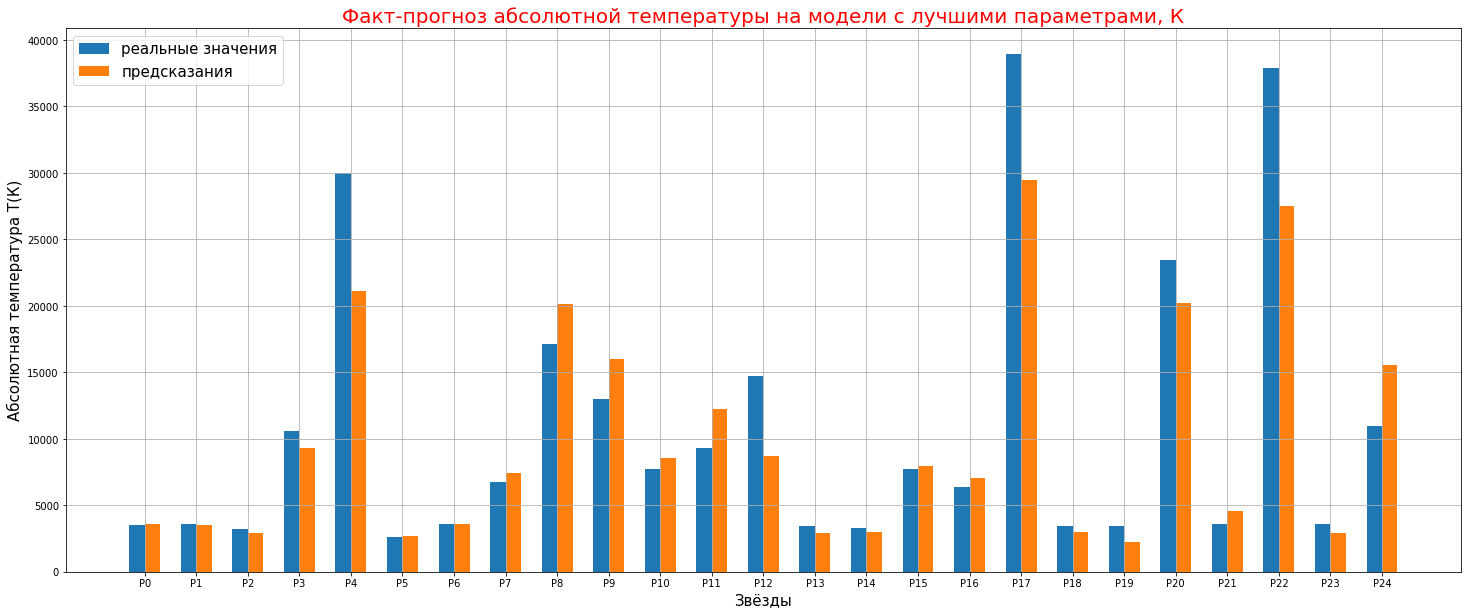

In [78]:
y_test_list = y_test_num.flatten().tolist()[:k]
test_preds_list = test_preds_num.flatten().tolist()[:k]

cat_par = [f"P{i}" for i in range(k)]
width = 0.3
x = np.arange(len(cat_par))
fig, ax = plt.subplots(figsize=(k, 10))
rects1 = ax.bar(x - width/2, y_test_list, width, label='реальные значения')
rects2 = ax.bar(x + width/2, test_preds_list, width, label='предсказания')
ax.set_title('Факт-прогноз абсолютной температуры на модели с лучшими параметрами, К', fontsize=20, color='red')
ax.set_xticks(x)
ax.set_xticklabels(cat_par)
ax.legend(fontsize=15)
ax.set_xlabel("Звёзды", fontsize=15)
ax.set_ylabel("Абсолютная температура Т(К)", fontsize=15)

ax.grid(True);

*Воспользовавшись дополнительными циклами для перебора скорости обучения learning_rate, размера батча batch_size, параметром доли исключения нейронов dropout р были собран датасет всех возможных параметров, затем среди них выбраны лучшие параметры по размеру RMSE. Также лучшая метрика была выбрана непосредственно из цикла, а с ней лучшие предсказания. Лучшая метрика RMSE= 4484. Лучшие параметры: р = 0, learning_rate = 0,1, batch_size = 30. 
Значания RMSE=4484 и $R^{2}$=0,82 на новой модели  по сравнению  со значениями на базовой модели (4806 и 0,79) говорят о том, что модель удалось улучшить. Исключение нейронов (dropout) не пригодилось (р=0).*

*На основе новых предсказаний построен график факт-прогноз. Из графика видно, что часто прогноз близок к реальному значению, но есть случаи, когда предсказание сильно отличается от рельного значения.*

#### Вывод-график:

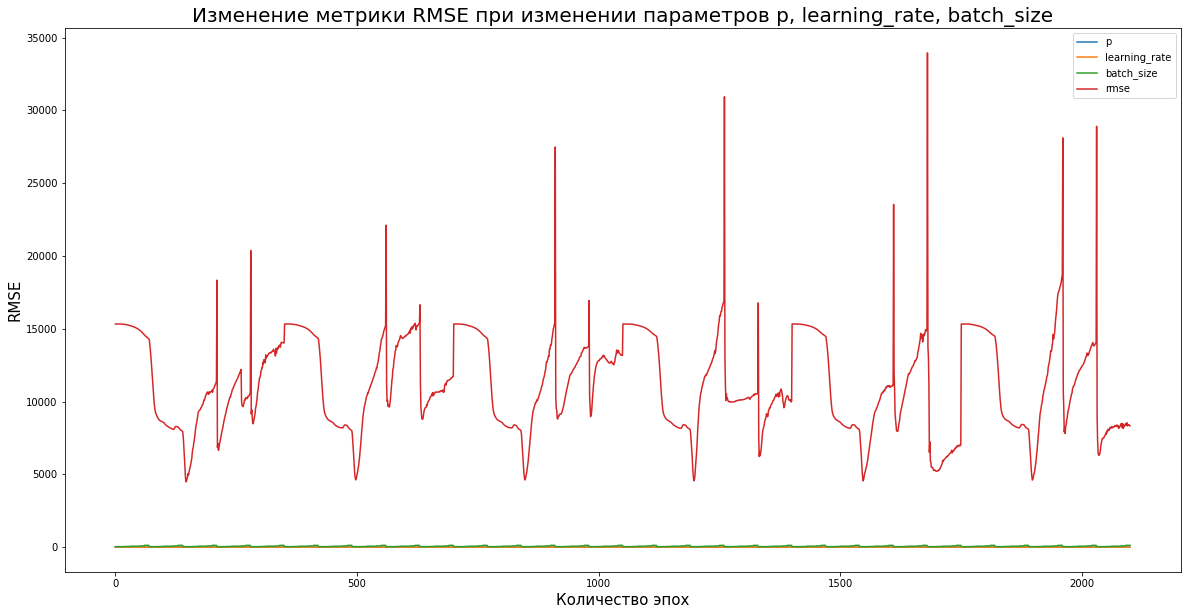

In [79]:
df[['p','learning_rate', 'batch_size', 'rmse']].plot(figsize=(20, 10))
plt.xlabel("Количество эпох", fontsize=15) 
plt.ylabel("RMSE", fontsize=15) 
plt.title("Изменение метрики RMSE при изменении параметров р, learning_rate, batch_size", fontsize=20)
plt.show()

На протяжении обучения модели с разными параметрами метрика увеличивалась до 35000 и уменьшалась. Иногда увеличивалась и уменьшалась резко, иногда постепенно.

In [80]:
df.columns

Index(['epoch', 'p', 'rmse_tr', 'learning_rate', 'batch_size', 'rmse', 'r2'], dtype='object')

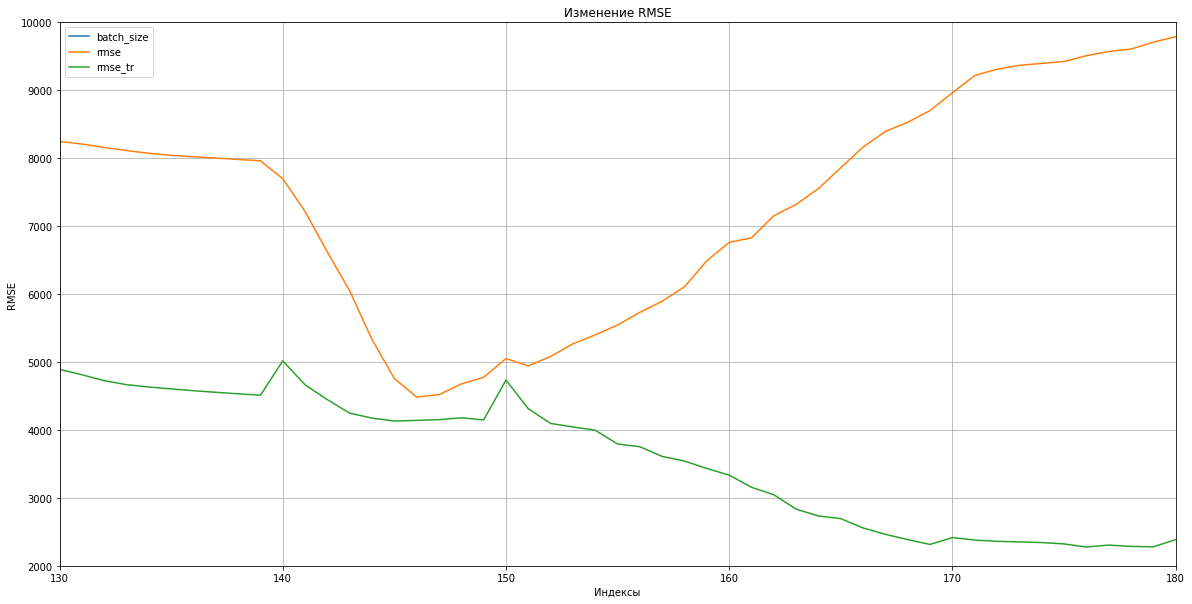

In [81]:
df[['batch_size', 'rmse', 'rmse_tr']].plot(figsize=(20, 10), xlim=(130,180), ylim=(2000, 10000),

                xlabel="Индексы",
                ylabel="RMSE",
                title="Изменение RMSE",                        
                grid=True);

Расмотрим график на более коротком участке, например на том, где метрика достигла минимума. Здесь одно деление - это 10 эпох, т.е. один прогон.

In [82]:
df_10 = df.groupby(df.index//10).agg({'rmse':'min'})

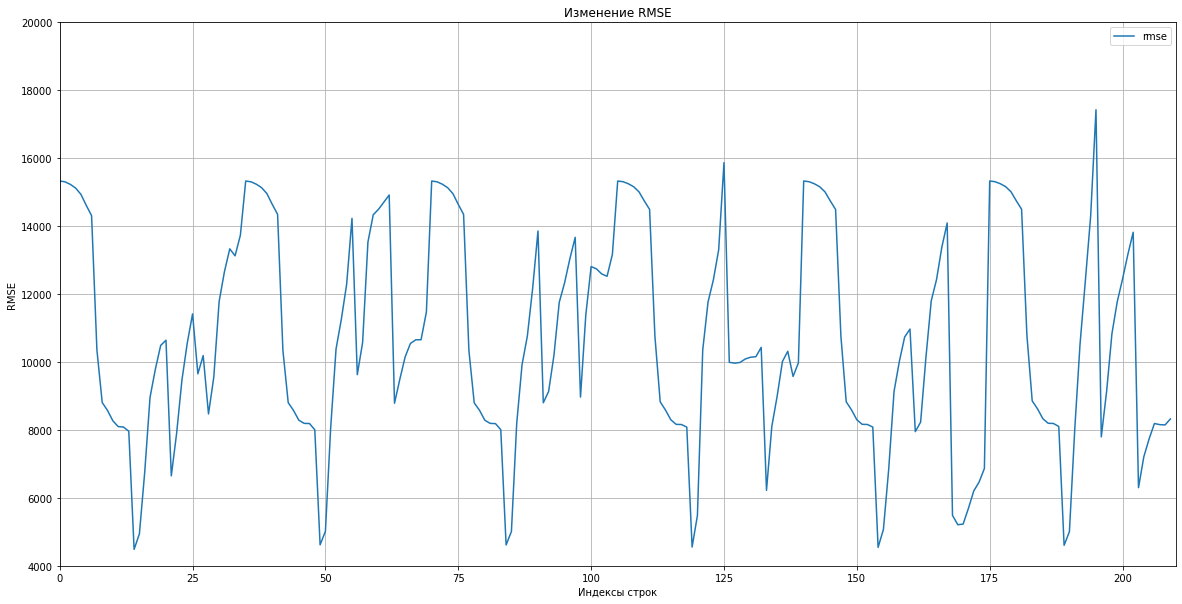

In [83]:
df_10.plot(figsize=(20, 10), xlim=(0,210), ylim=(4000, 20000),

                xlabel="Индексы строк",
                ylabel="RMSE",
                title="Изменение RMSE",
                grid=True);


Отразим как ведет себя минимальное значение метрики при каждом прогоне.Минимальное значение RMSE при изменении последовательно batch_size, learning_rate, параметра p снижается и снова увеличивается. 

 Во время каждого прогона модели метрика обычно самая высокая вначале, и меньше всего в конце. Но бывает, что метрика улучшается не на последней эпохе, а к последней эпохе ухудшается, т.е. алгоритм достиг минимума посередение выполнения.

Каждые 35 прогонов скорость постепенно увеличивается как и размер батча.При самом маленьком батче и одновременно маленькой скорости метрика превышает 13000. Значение метрики колеблется от 4500 до 18000.

График отражает минимум метрики RMSE примерно на 14 прогоне.

In [84]:
df.columns

Index(['epoch', 'p', 'rmse_tr', 'learning_rate', 'batch_size', 'rmse', 'r2'], dtype='object')

Text(0.5, 1.0, 'Изменение метрики RMSE при изменении параметров р, learning_rate')

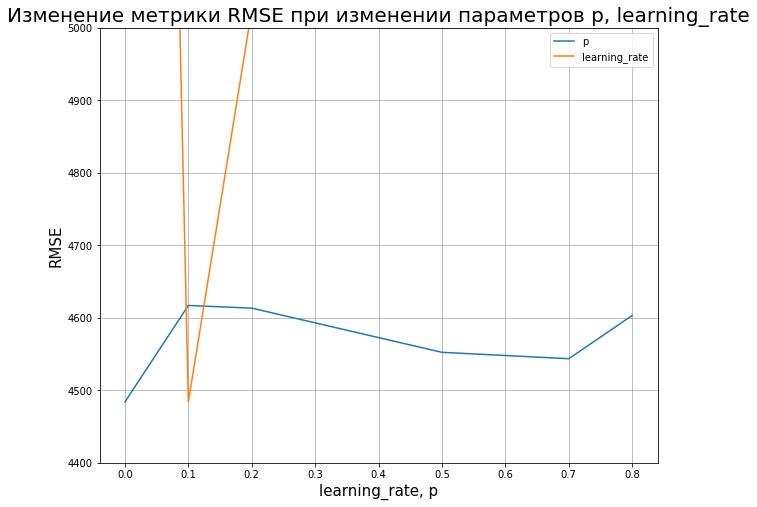

In [85]:
value_p = df.groupby('p')['rmse'].min() #находим минимальное значение метрики в зависимости от значения параметров
value_lr = df.groupby('learning_rate')['rmse'].min()
value_bs = df.groupby('batch_size')['rmse'].min()

plt.plot(value_p,label='p')
plt.plot(value_lr,label='learning_rate')
plt.ylim (4400, 5000)
plt.grid(True)
plt.legend()
plt.xlabel("learning_rate, р", fontsize=15) 
plt.ylabel("RMSE", fontsize=15) 
plt.title("Изменение метрики RMSE при изменении параметров р, learning_rate", fontsize=20)

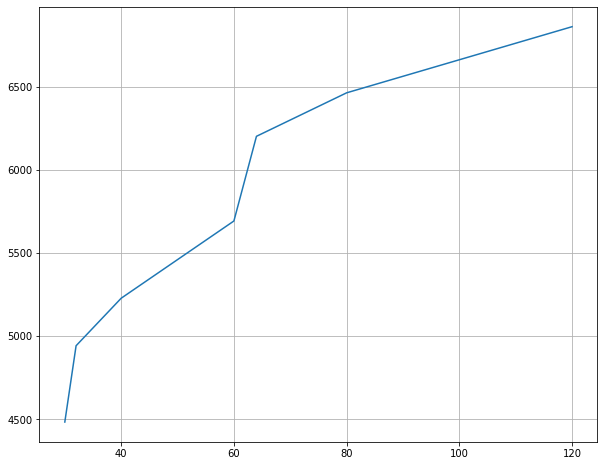

In [86]:
plt.plot(value_bs)
plt.grid(True)

Если взять наименьшие значения метрики при различных значениях параметров, то:
- в зависимости от значения параметра р лучшая метерика была минимальной при 0, а максимальной при 0,1. На протяжении роста р RMSE снижалась и росла.

- в зависимости от значения learning_rate лучшая метерика была минимальной при 0,1. На протяжении роста learning_rate RMSE снижалась и росла.

- в зависимости от значения batch_size лучшая метерика была минимальной при 30, а максимальной при 120. На протяжении роста размера батча метрика только росла.

In [87]:
print('Время выполнения кода',round((time.time() - start_1)/60,2), 'минут')

Время выполнения кода 2.2 минут


## Выводы

Для определения температуры на поверхности обнаруженных звёзд был применена нейросеть. 
В процессе выполнения проекта данные о существующих 240 звездах были предобработаны, исследованы признаки и их взаимосвязь между собой и целевым признаком, добавлен новые синтетические количественные признаки.
По принципу отсутствия мультиколлинеарности выбраны признаки для обучения, данные разделены на обучающие и валидационные. Количественные признаки масштабированы, категориальные закодированы, созданы обучающие и валидационные тензоры размером соответственно 168х23 и 72х23.

Сначала была построена базовая модель нейросети: архитектура слоев, функции активации, количество нейронов на каждом слое определены случайно. Модель обучена. Отражены значения метрики корня из среднеквадратичного отклонения на тренировочных данных для контроля переобучения, на тестовых данных и коэффициент детерминации. Результат этой модели неплохой, модель недообучена. RMSE достиг минимума на последней 90-й эпохе на значении примерно 4800 К. Коэффициент детерминации в этой точке 0,78, что говорит о том, что модель среднее объясняет зависимость между входными признаками и целевым. А построенный график-план-факт говорит о том, что прогноз часто близок к реальному значению.

Далее предприняты шаги по улучшению модели путем добавления в архитектуру модели регуляризации dropout. Путем перебора в циклах различных значений доли исключения нейронов р в dropout, скорости обучения learning_rate, размеров батчей batch_size найден минимальный RMSE = 4484. Также зафиксированы параметры при которых это значение достигнуто: р=0, learning_rate=0,1, batch_size=30. Лучшее значение достигнуто на 60-й эпохе прогона, с коэффициентом детерминации 0,82, что говорит о хорошем качестве созданной модели, модель улучшилась.  Построен график  факт-прогноз. В процессе подбора лучшей метрики был собран датасет со всеми параметрами и значениями метрик, на основе которого проанализировано поведение метрики.

Сравнение моделей говорит о том, что базовая модель - это только заготовка архитектуры, обучения. Главное, чтобы модель обучалась.
Вторая модель показывает, что базовую модель можно и нужно улучшать изменяя все параметры нейронной сети, которые можно изменить, для выявления параметров лучшей модели и наиболее качественного прогноза. 

Работа над улучшением качества модели может быть продолжена путем замены количественных признаков категориальными признаков, отсечением менее важных признаков. Также возможно попробовать разное количество слоев и их сочетание с функциями активации и количеством нейронов.

Код выполнен почти за две минуты.